# Sarcastic Headline Detection


[Prashant Brahmbhatt](https://github.com/hashbanger)

___

In [1]:
import re
import os
import nltk
import string
import warnings

import numpy as np
import pandas as pd

from plotly import tools
import plotly.offline as pyo
import plotly.graph_objs as go
import plotly.figure_factory as ff

import matplotlib.pyplot as plt

from collections import Counter

In [2]:
warnings.filterwarnings('ignore')

pyo.offline.init_notebook_mode(connected= True)

### Importing the Data

In [3]:
df = pd.read_json('Sarcasm_Headlines_Dataset.json', lines= True)

In [4]:
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [5]:
df.describe()

,is_sarcastic
count,26709.000000
mean,0.438953
std,0.496269
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 3 columns):
article_link    26709 non-null object
headline        26709 non-null object
is_sarcastic    26709 non-null int64
dtypes: int64(1), object(2)
memory usage: 626.1+ KB


In [7]:
for col in df.columns:
    print(sum(df.isnull()[col]))

0
0
0


So we have **no missing values**, that's good!

#### Adding the source of the article to the data

We can use the regular expression for finding the source of the article from the website

In [8]:
x = 'https://www.github.com'

In [9]:
re.findall('\w+', x)

['https', 'www', 'github', 'com']

In [10]:
df['source'] = df['article_link'].apply(lambda x: re.findall('\w+', x)[2])

In [11]:
df.head()

,article_link,headline,is_sarcastic,source
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0,huffingtonpost
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0,huffingtonpost
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1,theonion
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1,theonion
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0,huffingtonpost


First of all let's explore how much share are there of sarcasm in the dataset and what kind of are they.

In [12]:
labels = ['Sarcasm', 'Not Sarcasm']
values = [df['is_sarcastic'].sum(), len(df) - df['is_sarcastic'].sum()]

trace0 = go.Bar(x = [labels[1]], y = [values[1]], name = 'No Sarcasm')
trace1 = go.Bar(x = [labels[0]], y = [values[0]], marker= {'color': '#00cc66'} , name = 'Sarcasm')


data = [trace0, trace1]

layout = go.Layout(title = 'Number of Sarcastic Articles',
                   width = 800,
                   height = 500,
                  yaxis= dict(title = 'Number of articles'),)

fig = go.Figure(data, layout)

pyo.offline.iplot(fig)

In [13]:
df.head(10)

,article_link,headline,is_sarcastic,source
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0,huffingtonpost
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0,huffingtonpost
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1,theonion
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1,theonion
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0,huffingtonpost
5,https://www.huffingtonpost.com/entry/advancing...,advancing the world's women,0,huffingtonpost
6,https://www.huffingtonpost.com/entry/how-meat-...,the fascinating case for eating lab-grown meat,0,huffingtonpost
7,https://www.huffingtonpost.com/entry/boxed-col...,"this ceo will send your kids to school, if you...",0,huffingtonpost
8,https://politics.theonion.com/top-snake-handle...,top snake handler leaves sinking huckabee camp...,1,theonion
9,https://www.huffingtonpost.com/entry/fridays-m...,friday's morning email: inside trump's presser...,0,huffingtonpost


In [14]:
list(df['source'].value_counts())

[14985, 11724]

In [15]:
trace0 = go.Bar(x = df['source'].unique(), y = list(df['source'].value_counts()) , marker = {'color': '#9900e6'}, name = 'Sarcasm')

data = [trace0]

layout = go.Layout(title = 'Sources of Articles',
                   width = 800,
                   height = 500,
                  yaxis= dict(title = 'Number of articles'),)

fig = go.Figure(data, layout)

pyo.offline.iplot(fig)

So there's peculiar observation that all the articles in the data from ***theonion*** are sarcasm while all others are from ***huffington*** and not sarcastic.  

Seeing this observation we won't be using the sources column at all, it will be a biased model as in a way it is the target variable itself.

#### Removing the punctuations from the headlines

In [16]:
x = 'F*&!@#$%&*(U)+>"{}C<>!@#$K%&*()+>"{}<> T%&!@H#$%&*()+E>"{}<S>!@#$%&*()E+>"{}<> *&P(($UN#$$@!CT%$&UA&&*T()I$%@(O*&N!S'
print(x)
print('\n'+re.sub('[^a-zA-z0-9\s]','',x))

F*&!@#$%&*(U)+>"{}C<>!@#$K%&*()+>"{}<> T%&!@H#$%&*()+E>"{}<S>!@#$%&*()E+>"{}<> *&P(($UN#$$@!CT%$&UA&&*T()I$%@(O*&N!S

FUCK THESE PUNCTUATIONS


In [17]:
df['headlineNoPunc'] = df['headline'].apply(lambda x: re.sub('[^a-zA-z0-9\s]','',x))

In [18]:
print(df['headlineNoPunc'][456])
df['headline'][456]

donald trump thinks roger goodell is weak stupid and a dope


"donald trump thinks roger goodell is 'weak,' 'stupid' and a 'dope'"

Seems like it worked

#### Tokenizing the Sentences

In [19]:
allWords_df = df['headlineNoPunc'].str.split(expand = True).unstack().value_counts()
allWords_df = pd.DataFrame(allWords_df).reset_index()

In [20]:
trace0 = go.Bar(x = allWords_df['index'][0:50] , y = allWords_df[0][0:50], marker = dict(color = allWords_df[0]
                                                                                   , colorscale = 'Portland')
                                                                                , name = 'Top 50 Frequent Headline Words')

data = [trace0]

layout = go.Layout(title = 'Most Frequent Words',
                   width = 950,
                   height = 600,
                   xaxis = dict(title = 'Words', nticks = 50),
                  yaxis= dict(title = 'Count'),)

fig = go.Figure(data, layout)

pyo.offline.iplot(fig)

So it is pretty obvious that the most frequent words are the *stopwords*. So we better remove these from the data to get to the real stuff.

In [21]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\prash\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [22]:
from nltk.corpus import stopwords

In [23]:
word_counts = df['headlineNoPunc'].str.split(expand = True).unstack().value_counts()
word_counts = pd.DataFrame(word_counts).reset_index()

separating out the word counts based on their target class

In [24]:
stopwords = stopwords.words('english') # let's save us some hassle

In [25]:
noSarcasmWords_all = df[df['is_sarcastic'] == 0]['headlineNoPunc'].str.split(expand = True).unstack()
sarcasmWords_all = df[df['is_sarcastic'] == 1]['headlineNoPunc'].str.split(expand = True).unstack()

In [26]:
noSarcasmWords = [wo for wo in noSarcasmWords_all if wo not in stopwords]
sarcasmWords = [wo for wo in sarcasmWords_all if wo not in stopwords]

Now we get the counts of the words

In [27]:
from collections import Counter

In [28]:
noSarcasmWordCount = pd.DataFrame(list(Counter(noSarcasmWords).items()), columns= ['word','count'])
sarcasmWordCount = pd.DataFrame(list(Counter(sarcasmWords).items()), columns= ['word','count'])

In [29]:
temp1 = noSarcasmWordCount.sort_values(by = ['count'], ascending= False)[1:31]
temp2 = sarcasmWordCount.sort_values(by = ['count'], ascending= False)[1:31]

In [32]:
trace0 = go.Bar(y = temp1['word'] , x = temp1['count'], marker = dict(color = '#ff3333'), opacity= 0.6, orientation = 'h' ,name = 'Frequent words in Non Sarcastic articles')
trace1 = go.Bar(y = temp2['word'] , x = temp2['count'], marker = dict(color = '#33cc33'), opacity= 0.6, orientation = 'h' ,name = 'Frequent words in Sarcastic articles')

fig = tools.make_subplots(rows= 1, cols= 2)
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=600, width=1200, title = 'Frequent words', yaxis = dict(nticks = 30))
                     
pyo.offline.iplot(fig)

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



### Lemmatization

In [33]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\prash\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\prash\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Here we can see the Lemmatization of a sample sentence

In [34]:
from nltk.stem import WordNetLemmatizer

In [35]:
wordnet_lemmatizer = WordNetLemmatizer()

sentence = "i am trying, he is frying, she learned shit, i mowed the lawn"

sentence_words = sentence.split()

sentence_words = [re.sub('[^a-zA-z0-9\s]','',x) for x in sentence_words]
print(sentence_words)
sentence_words
print("{0:20}{1:20}".format("Word","Lemma"))
for word in sentence_words:
    print ("{0:20}{1:20}".format(word,wordnet_lemmatizer.lemmatize(word, pos = 'v')))

['i', 'am', 'trying', 'he', 'is', 'frying', 'she', 'learned', 'shit', 'i', 'mowed', 'the', 'lawn']
Word                Lemma               
i                   i                   
am                  be                  
trying              try                 
he                  he                  
is                  be                  
frying              fry                 
she                 she                 
learned             learn               
shit                shit                
i                   i                   
mowed               mow                 
the                 the                 
lawn                lawn                


Now we can use the above approach to lemmaize our both of the lists

In [36]:
noSarcasmWords_lemm = []
for word in noSarcasmWords:
    if word != None:
        noSarcasmWords_lemm.append(wordnet_lemmatizer.lemmatize(word, pos = 'v'))

sarcasmWords_lemm = []
for word in sarcasmWords:
    if word != None:
        sarcasmWords_lemm.append(wordnet_lemmatizer.lemmatize(word, pos = 'v'))

In [37]:
print('finding' in noSarcasmWords)

print('finding' in noSarcasmWords_lemm)
print('find' in noSarcasmWords_lemm)

True
False
True


See! We're good!

___

### Wordclouds

In [38]:
from wordcloud import WordCloud

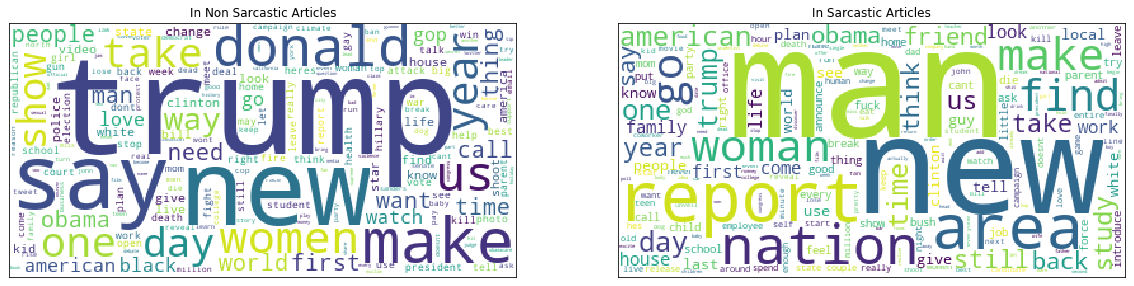

In [39]:
sar_cloud1 = WordCloud(background_color= 'white', colormap= 'viridis').generate(" ".join(noSarcasmWords_lemm))
sar_cloud2 = WordCloud(background_color= 'white', colormap= 'viridis').generate(" ".join(sarcasmWords_lemm))


fig = plt.figure(figsize=(20,20))

ax1 = fig.add_subplot(1, 2, 1)
ax1.tick_params(length=0, width=0)
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.set_title("In Non Sarcastic Articles")
ax1.imshow(sar_cloud1)

ax2 = fig.add_subplot(1, 2, 2)
ax2.tick_params(length=0, width=0)
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.set_title("In Sarcastic Articles")
ax2.imshow(sar_cloud2)

plt.show()

___

### Bi- grams

In [40]:
bigrams = list(nltk.bigrams(sarcasmWords_lemm))
bigram_counts = Counter(bigrams)

bigram_name = []
bigram_freq = []
for key in bigram_counts.keys():
    if bigram_counts[key] > 1:
        bigram_name.append(str(key))
        bigram_freq.append(bigram_counts[key])
        
bigram_df = pd.DataFrame({'bigram_names': bigram_name, 'bigram_freq': bigram_freq})


# our values in the first columns look like '('doctor', 'man')'
# Let's clean it up to 'doctor man'

bigram_df['bigram_names'] = [re.sub('[^a-zA-z0-9\s]','',x) for x in bigram_df['bigram_names']]

bigram_df.head()

,bigram_names,bigram_freq
0,doctor man,2
1,man clinton,6
2,man dad,4
3,teacher area,3
4,friends man,2


This looks fine now!

In [41]:
temp = bigram_df.sort_values(by = 'bigram_freq')[-20:]
trace0 = go.Bar(y = temp['bigram_names'] , x = temp['bigram_freq'], orientation= 'h', marker = dict(color = '#00997a')
               , opacity = 0.6, showlegend = False)

fig = tools.make_subplots(1,2, subplot_titles = ['in Sarcasm Articles','in Non Sarcasm Articles'] ,horizontal_spacing = 0.05, shared_xaxes = False)
fig.append_trace(trace0, 1, 1)

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



Now we do the same for non sarcastic articles and append its plot to the grid

In [42]:
bigrams = list(nltk.bigrams(noSarcasmWords_lemm))
bigram_counts = Counter(bigrams)

bigram_name = []
bigram_freq = []
for key in bigram_counts.keys():
    if bigram_counts[key] > 1:
        bigram_name.append(str(key))
        bigram_freq.append(bigram_counts[key])
        
bigram_df = pd.DataFrame({'bigram_names': bigram_name, 'bigram_freq': bigram_freq})

bigram_df['bigram_names'] = [re.sub('[^a-zA-z0-9\s]','',x) for x in bigram_df['bigram_names']]

bigram_df.head()

,bigram_names,bigram_freq
0,give spicer,2
1,donald donald,6
2,un one,2
3,4 trump,3
4,mom donald,2


In [43]:
temp = bigram_df.sort_values(by = 'bigram_freq')[-20:]
trace1 = go.Bar(y = temp['bigram_names'] , x = temp['bigram_freq'], orientation= 'h', marker = dict(color = '#00e6b8')
                , showlegend = False, opacity = 0.6)
fig.append_trace(trace1, 1, 2)
fig['layout'].update( height=600, width=1100, title = 'Bigrams', yaxis = dict(nticks = 20))
pyo.offline.iplot(fig)

___

### Adding new Features

Here we will add some meta features of the headlines

In [44]:
# Finding the number of words in the headline
df['num_words'] = df['headlineNoPunc'].apply(lambda x: len(x.split()))

# the unique number of words in the headline
df['unique_num_words'] = df['headlineNoPunc'].apply(lambda x: len(set(x.split())))

# the number of characters in the headline
df['num_chars'] = df['headline'].apply(lambda x: len(x))

# number of genuine words with no stopwords  
df['num_words_nostop'] = df['headlineNoPunc'].apply(lambda xx: len([x for x in xx.split() if x not in stopwords]))

# number of stopwords
df['num_stop'] = df['num_words'] - df['num_words_nostop']

# number of punctuations
df['num_punc'] = df['headline'].apply(lambda xx: len([x for x in xx if x in string.punctuation]))

In [45]:
trace0 = go.Box(y = df[df['is_sarcastic'] == 0]['num_words'], name = 'Non Sarcasm')
trace1 = go.Box(y = df[df['is_sarcastic'] == 1]['num_words'], name = 'Sarcasm')
data = [trace0, trace1]
layout = go.Layout(title = 'Number of Words',
                   width = 900,
                   height = 600)
fig = go.Figure(data, layout)
pyo.offline.iplot(fig)

In [46]:
trace0 = go.Box(y = df[df['is_sarcastic'] == 0]['unique_num_words'], name = 'Non Sarcasm')
trace1 = go.Box(y = df[df['is_sarcastic'] == 1]['unique_num_words'], name = 'Sarcasm')
data = [trace0, trace1]
layout = go.Layout(title = 'Number of Unique Words',
                   width = 900,
                   height = 600)
fig = go.Figure(data, layout)
pyo.offline.iplot(fig)

In [47]:
trace0 = go.Box(y = df[df['is_sarcastic'] == 0]['num_chars'], name = 'Non Sarcasm')
trace1 = go.Box(y = df[df['is_sarcastic'] == 1]['num_chars'], name = 'Sarcasm')
data = [trace0, trace1]
layout = go.Layout(title = 'Number of Characters',
                   width = 900,
                   height = 600)
fig = go.Figure(data, layout)
pyo.offline.iplot(fig)

In [48]:
trace0 = go.Box(y = df[df['is_sarcastic'] == 0]['num_punc'], name = 'Non Sarcasm')
trace1 = go.Box(y = df[df['is_sarcastic'] == 1]['num_punc'], name = 'Sarcasm')
data = [trace0, trace1]
layout = go.Layout(title = 'Number of Punctuations',
                   width = 900,
                   height = 600)
fig = go.Figure(data, layout)
pyo.offline.iplot(fig)

___

### Predictive Modeling

#### Preprocessing the data

In [49]:
from sklearn.preprocessing import LabelEncoder

In [50]:
X = df['headlineNoPunc']
y = df['is_sarcastic']

In [51]:
enc = LabelEncoder()
y = enc.fit_transform(y)
y = y.reshape(-1,1)

In [52]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 101)

#### Creating the RNN

In [53]:
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

Using TensorFlow backend.


In [54]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words= max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences, max_len)

We save the tokenizer so we could use it when testing single user inputs and don't need to re fit

In [55]:
import pickle
pickle.dump(tok,open('tokenizer.pkl','wb'))

In [56]:
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.models import Model

In [57]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.2)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [58]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 150)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 150, 50)           50000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)  

We will save the model checkpoint after every epoch so we don't lose progress. We can use it or if we want to use pickle if the model is finsihed one that 'll work fine too.

In [59]:
checkpoint_path = "model.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create checkpoint callback
cp_callback = keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [92]:
from keras.callbacks import EarlyStopping
model.fit(sequences_matrix,y_train,batch_size=100,epochs=3,
          validation_split=0.1,callbacks=[cp_callback])

Train on 18027 samples, validate on 2004 samples
Epoch 1/3
18027/18027 [==============================] - 135s 7ms/step - loss: 0.3571 - acc: 0.8402 - val_loss: 0.3792 - val_acc: 0.8268

Epoch 00001: saving model to model.ckpt
Epoch 2/3
18027/18027 [==============================] - 135s 7ms/step - loss: 0.3445 - acc: 0.8452 - val_loss: 0.3920 - val_acc: 0.8179

Epoch 00002: saving model to model.ckpt
Epoch 3/3
18027/18027 [==============================] - 132s 7ms/step - loss: 0.3355 - acc: 0.8499 - val_loss: 0.3904 - val_acc: 0.8273

Epoch 00003: saving model to model.ckpt


Saving the model as pickle

In [82]:
pickle.dump(model,open('model.pkl','wb'))

If you use checkpoint rather than pickle then use following

In [60]:
# model_2 = RNN()
# model_2.summary()
# model_2.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 150)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 150, 50)           50000     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_3 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257       
__________

In [85]:
# model_2.load_weights('model.ckpt')

___

#### Testing on the test set

In [62]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [63]:
accr = model_loaded.evaluate(test_sequences_matrix,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

6678/6678 [==============================] - 54s 8ms/step
Test set
  Loss: 0.406
  Accuracy: 0.819


### Testing User Input Headlines

In [12]:
import re
import pickle
import string
import pandas as pd
from keras.preprocessing import sequence
from warnings import filterwarnings

filterwarnings('ignore')

max_words = 1000
max_len = 150

loading the pickles

In [13]:
model_loaded = pickle.load(open('model.pkl', 'rb'))
token = pickle.load(open('tokenizer.pkl', 'rb'))

In [24]:
def detect_sarcasm(sent):
    sent = re.sub('[^a-zA-z0-9\s]','',sent)
    inp_sent = pd.Series([sent])
    seq = token.texts_to_sequences(inp_sent)
    sequences_matrix = sequence.pad_sequences(seq, max_len)
    res = model_loaded.predict(sequences_matrix)
    
    if res[0][0] <= 0.5:
        print("\nNah! seems legit!")
    if res[0][0] > 0.5:
        print("\nThis shit is sarcastic bro!")

In [23]:
detect_sarcasm(input().lower())

Donald Trump is the president
donald trump is the president

Nah! seems legit!


### de nada!